# Chapter 2

## 2E1

Which of the expressions below correspond to the statement: the probability of rain on Monday? 

(1) $Pr(\text{rain})$  
(2) $Pr(\text{rain|Monday})$  
(3) $Pr(\text{Monday|rain})$  
(4) $Pr(\text{rain, Monday})/ Pr(\text{Monday})$ 

### Ans

$$
\frac{Pr(\text{rain, Monday})}{Pr(\text{Monday})} = Pr(\text{rain} \mid \text{Monday})
$$


## 2E2

Which of the following statements corresponds to the expression: $Pr(\text{Monday} \mid \text{rain})$? 

(1) The probability of rain on Monday.  
(2) The probability of rain, given that it is Monday.  
(3) The probability that it is Monday, given that it is raining.  
(4) The probability that it is Monday and that it is raining.  


### Ans

(3) The probability that it is Monday, given that it is raining.

## 2E3

2E3. Which of the expressions below correspond to the statement: _the probability that it is Monday, given that it is raining_?

(1) $Pr(\text{Monday} \mid \text{rain})$

(2) $Pr(\text{rain} \mid \text{Monday})$

(3) $Pr(\text{rain} \mid \text{Monday}) \cdot Pr(\text{Monday})$

(4) $Pr(\text{rain} \mid \text{Monday}) \cdot Pr(\text{Monday}) / Pr(\text{rain})$

(5) $Pr(\text{Monday} \mid \text{rain}) \cdot Pr(\text{rain}) / Pr(\text{Monday})$

### Ans

(1) $Pr(\text{Monday} \mid \text{rain})$

(4) 
$$
\begin{equation}
\begin{aligned}
Pr(\text{rain} \mid \text{Monday}) \cdot Pr(\text{Monday}) / Pr(\text{rain}) 
&= \frac{Pr(\text{rain}, \text{Monday})}{Pr(\text{rain})} \\
&= Pr(\text{Monday} \mid \text{rain}) \\
\end{aligned}
\end{equation}
$$


## 2E4.

The Bayesian statistician Bruno de Finetti (1906–1985) began his 1973 book on probability theory with the declaration: “PROBABILITY DOES NOT EXIST.” The capitals appeared in the original,  so I imagine de Finetti wanted us to shout this statement. What he meant is that probability is a device for describing uncertainty from the perspective of an observer with limited knowledge; it has no  objective reality. Discuss the globe tossing example from the chapter, in light of this statement. What  does it mean to say “the probability of water is 0.7”?

### Ans


In the case of the globe tossing example, it means that there is some "true" proportion of water to land. However, "truth"s like thees are usually fully known to us for many reasons (e.g. due to finite sample size, measurement error, unobserved variables, missing data, etc.). We can model our uncertainty using probability theory. Hopefully our model correctly represents truths, such as the "true" proportion of water to land. However, that's not guaranteed. When we say "the probability of water is 0.7," colloquially, it means that we *think* that the probability of water is somewhere around 70%, given this point in time. We did not give a lot of significant digits. It might not actually be exactly 0.7, but we _think_ it is somewhere around there. It still denotes uncertainty of the observer, given what we currently know.


## 2M1.

2M1. Recall the globe tossing model from the chapter. Compute and plot the grid approximate  posterior distribution for each of the following sets of observations. In each case, assume a uniform  prior for p.  

(1) W, W, W  
(2) W, W, W, L  
(3) L, W, W, L, W, W, W 

### Ans

We'll instead use rejection sampling and ABC-SMC:

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 169.70it/s]


(<Figure size 576x576 with 4 Axes>,
 array([<AxesSubplot:title={'center':'obs: [1 1 1]'}, ylabel='Density'>,
        <AxesSubplot:title={'center':'after [1 1 1 0]'}, ylabel='Density'>,
        <AxesSubplot:title={'center':'after [0 1 1 0 1 1 1]'}, ylabel='Density'>,
        <AxesSubplot:title={'center':'Full batch'}, ylabel='Density'>],
       dtype=object))

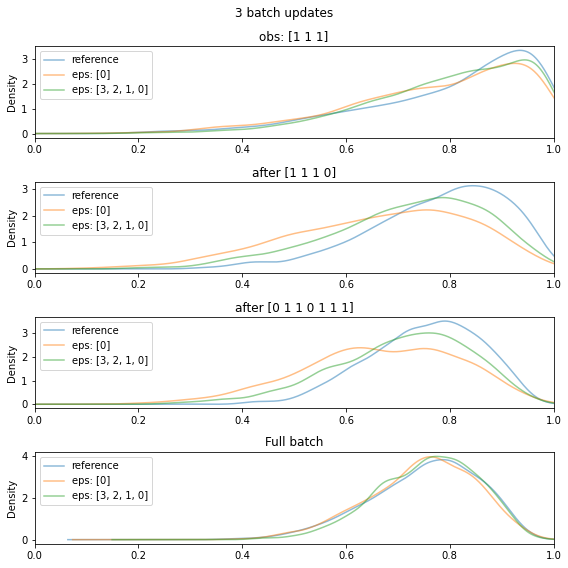

In [5]:
import numpy as np
import pandas as pd
from unlikely.models import Models, Model
from unlikely.priors import Beta
from unlikely.engine import abc_smc
from unlikely.misc import create_images_from_data


num_particles = 2000
obs = np.array([
    1,1,1,
    1,1,1,0,
    0,1,1,0,1,1,1
])

epsilons_list = [[0], [3,2,1,0]]


def distance(x,y):
    """
    Compare the number of ones in one vs. the other.
    """
    return abs(x.sum() - y.sum())

def simulate(priors, obs):
    """
    Data is binomially distributed.
    """
    return np.random.binomial(n=1, p=priors['beta'], size=len(obs))


data_to_display = [
    [
        {
            'title': f"obs: {obs[:3]}",
            'data': [
                pd.DataFrame({
                    'reference': np.random.beta(
                        obs[:3].sum() + 1, 
                        len(obs[:3]) - obs[:3].sum() + 1,
                        num_particles
                    )
                })

            ]
        },
        {
            'title': f"after {obs[3:7]}",
            'data': [
                pd.DataFrame({
                    'reference': np.random.beta(
                        obs[:7].sum() + 1, 
                        len(obs[:7]) - obs[:7].sum() + 1,
                        num_particles
                    )
                })
            ]
        },
        {
            'title': f"after {obs[7:]}",
            'data': [
                pd.DataFrame({
                    'reference': np.random.beta(
                        obs.sum() + 1, 
                        len(obs) - obs.sum() + 1,
                        num_particles
                    )
                })
            ]
        },
        {
            'title': "Full batch",
            'data': [
                pd.DataFrame({
                    'reference': np.random.beta(
                        obs.sum() + 1, 
                        len(obs) - obs.sum() + 1,
                        num_particles
                    )
                })
            ]
        }
    ]
]


for row, epsilons in enumerate(epsilons_list):
    models = Models(
        [
            Model(
                name='flat prior',
                priors=[
                    Beta(alpha=1, beta=1, name="beta"),
                ],
                simulate=simulate,
                prior_model_proba=1,
            ),
        ]
    )

    # Update with 1st batch
    abc_smc(
        num_particles=num_particles,
        epsilons=epsilons,
        models=models,
        obs=obs[:3],
        distance=distance,
    )

    data_to_display[0][0]['data'].append(
        pd.DataFrame(models[0].prev_accepted_proposals).rename(
            columns={'beta': f'eps: {epsilons}'}
        )
    )


    # The posterior distribution becomes the prior
    models.use_distribution_from_samples()

    # Update with 2nd batch
    abc_smc(
        num_particles=num_particles,
        epsilons=epsilons,
        models=models,
        obs=obs[3:7],
        distance=distance,
    )

    # The posterior distribution becomes the prior
    models.use_distribution_from_samples()
    
    data_to_display[0][1]['data'].append(
        pd.DataFrame(
            models[0].prev_accepted_proposals).rename(
            columns={'beta': f'eps: {epsilons}'}
        )
    )

    # Update with 3rd batch
    abc_smc(
        num_particles=num_particles,
        epsilons=epsilons,
        models=models,
        obs=obs[7:],
        distance=distance,
    )

    data_to_display[0][2]['data'].append(
        pd.DataFrame(
            models[0].prev_accepted_proposals).rename(
            columns={'beta': f'eps: {epsilons}'}
        )
    )

    models_full_batch = Models(
        [
            Model(
                name='flat prior',
                priors=[
                    Beta(alpha=1, beta=1, name="beta"),
                ],
                simulate=simulate,
                prior_model_proba=1,
            ),
        ]
    )

    # Update full batch
    abc_smc(
        num_particles=num_particles,
        epsilons=epsilons,
        models=models_full_batch,
        obs=obs,
        distance=distance,
    )
    
    data_to_display[0][3]['data'].append(
        pd.DataFrame(
            models_full_batch[0].prev_accepted_proposals
        ).rename(columns={'beta': f'eps: {epsilons}'})
    )

create_images_from_data(
    data={
        'title': '3 batch updates',
        'data': data_to_display
    },
    xlim=(0,1),
    figsize_mult=(2,8)
)

Using the [unlikely](https://github.com/Edderic/unlikely) library, Bayesian updating with the full batch, seems to be more accurate than updating through mini batches. Mini batch updating leads to overinflated posterior distributions.

## 2M2

Now assume a prior for p that is equal to zero when p < 0.5 and is a positive constant when  p ≥ 0.5. Again compute and plot the grid approximate posterior distribution for each of the sets of observations in the problem just above. 

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 248.04it/s]


(<Figure size 576x576 with 4 Axes>,
 array([<AxesSubplot:title={'center':'obs: [1 1 1]'}, ylabel='Density'>,
        <AxesSubplot:title={'center':'after [1 1 1 0]'}, ylabel='Density'>,
        <AxesSubplot:title={'center':'after [0 1 1 0 1 1 1]'}, ylabel='Density'>,
        <AxesSubplot:title={'center':'Full batch'}, ylabel='Density'>],
       dtype=object))

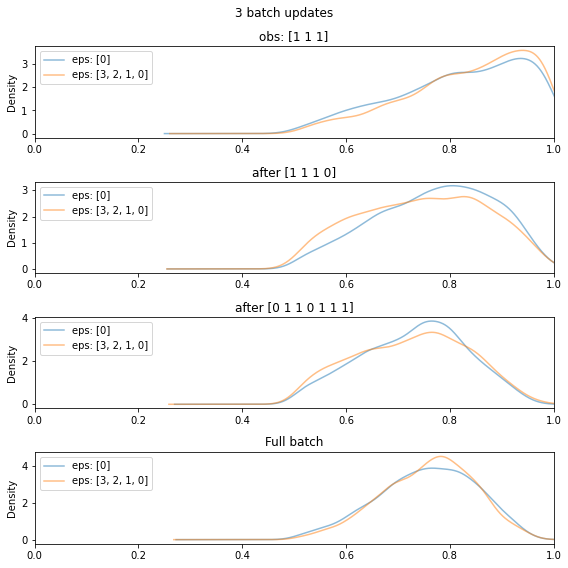

In [1]:
import numpy as np
import pandas as pd
from unlikely.models import Models, Model
from unlikely.priors import Uniform
from unlikely.engine import abc_smc
from unlikely.misc import create_images_from_data
import pdb

num_particles = 2000
obs = np.array([
    1,1,1,
    1,1,1,0,
    0,1,1,0,1,1,1
])

epsilons_list = [[0], [3,2,1,0]]


def distance(x,y):
    """
    Compare the number of ones in one vs. the other.
    """
    return abs(x.sum() - y.sum())

def simulate(priors, obs):
    """
    Data is binomially distributed.
    """
    try:
        return np.random.binomial(n=1, p=priors['uniform'], size=len(obs))
    except ValueError as e:
        pdb.set_trace()

data_to_display = [
    [
        {
            'title': f"obs: {obs[:3]}",
            'data': []
        },
        {
            'title': f"after {obs[3:7]}",
            'data': []
        },
        {
            'title': f"after {obs[7:]}",
            'data': []
        },
        {
            'title': "Full batch",
            'data': []
        }
    ]
]


for row, epsilons in enumerate(epsilons_list):
    models = Models(
        [
            Model(
                name='Uniform over (0.5, 1)',
                priors=[
                    Uniform(alpha=0.5, beta=1, name="uniform"),
                ],
                simulate=simulate,
                prior_model_proba=1,
            ),
        ]
    )

    # Update with 1st batch
    abc_smc(
        num_particles=num_particles,
        epsilons=epsilons,
        models=models,
        obs=obs[:3],
        distance=distance,
    )

    data_to_display[0][0]['data'].append(
        pd.DataFrame(models[0].prev_accepted_proposals).rename(
            columns={'uniform': f'eps: {epsilons}'}
        )
    )


    # The posterior distribution becomes the prior
    models.use_distribution_from_samples()

    # Update with 2nd batch
    abc_smc(
        num_particles=num_particles,
        epsilons=epsilons,
        models=models,
        obs=obs[3:7],
        distance=distance,
    )

    # The posterior distribution becomes the prior
    models.use_distribution_from_samples()
    
    data_to_display[0][1]['data'].append(
        pd.DataFrame(
            models[0].prev_accepted_proposals).rename(
            columns={'uniform': f'eps: {epsilons}'}
        )
    )

    # Update with 3rd batch
    abc_smc(
        num_particles=num_particles,
        epsilons=epsilons,
        models=models,
        obs=obs[7:],
        distance=distance,
    )

    data_to_display[0][2]['data'].append(
        pd.DataFrame(
            models[0].prev_accepted_proposals).rename(
            columns={'uniform': f'eps: {epsilons}'}
        )
    )

    models_full_batch = Models(
        [
            Model(
                name='flat prior',
                priors=[
                    Uniform(alpha=0.5, beta=1, name="uniform"),
                ],
                simulate=simulate,
                prior_model_proba=1,
            ),
        ]
    )

    # Update full batch
    abc_smc(
        num_particles=num_particles,
        epsilons=epsilons,
        models=models_full_batch,
        obs=obs,
        distance=distance,
    )
    
    data_to_display[0][3]['data'].append(
        pd.DataFrame(
            models_full_batch[0].prev_accepted_proposals
        ).rename(columns={'uniform': f'eps: {epsilons}'})
    )

create_images_from_data(
    data={
        'title': '3 batch updates',
        'data': data_to_display
    },
    xlim=(0,1),
    figsize_mult=(2,8)
)